# import packages

In [1093]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, make_scorer
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from xgboost import XGBClassifier
import shap
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score

# data load

In [1094]:
df_survey=pd.read_excel('DataSet_Final.xlsx',sheet_name='Survey Dataset')

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [1095]:
df_survey.head(2)

,ID,YeshuvAvoda,ShemAvoda,SugAvoda,ShemMachlaka,SugMachlaka,EzoAvoda,TeurPeula,TeurTafkid,MenahelEtMi,MaamadAvoda,MakorSachar,TeudaGvoha,shnotlimud,Gil,TarichHathala,SemelAnafSofi,SemelMishlachSofi
0,1.0,ירושלים,"למ""ס","איסוף, עיבוד ופרסום נתונים",מיקרו כלכלה,טיפול בנתוני מיקרו,סגן מנהל אגף,"כנ""ל",סגן מנהל אגף,3.0,1.0,1.0,6.0,22.0,55.0,2020-06-15,8411,2120
1,2.0,ירושלים,בית חולים הדסה עין כרם,טיפול בחולים,רדיואתרפיה,טיפול בחולי סרטן,טכנאית רדיותרפיה,"כנ""ל","כנ""ל",NaN,1.0,1.0,6.0,22.0,55.0,2022-07-01,8610,3311


In [1096]:
df_survey.shape

(201, 18)

# EDA

### check how many unique values

In [1097]:
df_survey.nunique()

,0
ID,200
YeshuvAvoda,21
ShemAvoda,82
SugAvoda,78
ShemMachlaka,61
SugMachlaka,35
EzoAvoda,84
TeurPeula,32
TeurTafkid,16
MenahelEtMi,4


In [1098]:
df_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 200 non-null    float64       
 1   YeshuvAvoda        200 non-null    object        
 2   ShemAvoda          200 non-null    object        
 3   SugAvoda           175 non-null    object        
 4   ShemMachlaka       136 non-null    object        
 5   SugMachlaka        66 non-null     object        
 6   EzoAvoda           193 non-null    object        
 7   TeurPeula          64 non-null     object        
 8   TeurTafkid         28 non-null     object        
 9   MenahelEtMi        33 non-null     float64       
 10  MaamadAvoda        198 non-null    float64       
 11  MakorSachar        186 non-null    float64       
 12  TeudaGvoha         198 non-null    float64       
 13  shnotlimud         198 non-null    float64       
 14  Gil       

In [1099]:
#there is null in sex column
df_survey.isnull().sum()

,0
ID,1
YeshuvAvoda,1
ShemAvoda,1
SugAvoda,26
ShemMachlaka,65
SugMachlaka,135
EzoAvoda,8
TeurPeula,137
TeurTafkid,173
MenahelEtMi,168


In [1100]:
# when we remove the row with the NULL id there are 12 columns with nulls
df_survey[~df_survey['ID'].isnull()].isnull().sum()

,0
ID,0
YeshuvAvoda,0
ShemAvoda,0
SugAvoda,25
ShemMachlaka,64
SugMachlaka,134
EzoAvoda,7
TeurPeula,136
TeurTafkid,172
MenahelEtMi,168


In [1101]:
df_survey[df_survey['TeudaGvoha'].isnull()]

,ID,YeshuvAvoda,ShemAvoda,SugAvoda,ShemMachlaka,SugMachlaka,EzoAvoda,TeurPeula,TeurTafkid,MenahelEtMi,MaamadAvoda,MakorSachar,TeudaGvoha,shnotlimud,Gil,TarichHathala,SemelAnafSofi,SemelMishlachSofi
44,45.0,ירושלים,מסעדה,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-01,5610,XXXX
107,108.0,בת ים,מסעדה,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-01,5610,XXXX
200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.725,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


In [1102]:
#check if there are weird data
df_survey.describe()

,ID,MenahelEtMi,MaamadAvoda,MakorSachar,TeudaGvoha,shnotlimud,Gil,TarichHathala
count,200.000000,33.000000,198.000000,186.000000,198.000000,198.000000,198.000000,200
mean,100.500000,2.143182,1.409091,1.338710,4.126263,14.313131,39.454545,2017-07-10 14:38:24
min,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,22.000000,1999-06-06 00:00:00
25%,50.750000,1.725000,1.000000,1.000000,3.000000,12.000000,31.000000,2011-11-08 12:00:00
50%,100.500000,2.000000,1.000000,1.000000,4.000000,14.000000,37.000000,2022-04-01 00:00:00
75%,150.250000,3.000000,1.000000,1.000000,5.000000,16.000000,46.000000,2022-11-11 00:00:00
max,200.000000,3.000000,6.000000,4.000000,7.000000,22.000000,78.000000,2026-06-06 00:00:00
std,57.879185,0.798418,1.250104,0.711532,1.324972,2.917291,12.611149,NaN


In [1103]:
#there are TarichHathala in 2026 , need to verify with the buisness if there are future date for job

# Correlation test

In [1104]:
df_survey.columns

Index(['ID', 'YeshuvAvoda', 'ShemAvoda', 'SugAvoda', 'ShemMachlaka',
       'SugMachlaka', 'EzoAvoda', 'TeurPeula', 'TeurTafkid', 'MenahelEtMi',
       'MaamadAvoda', 'MakorSachar', 'TeudaGvoha', 'shnotlimud', 'Gil',
       'TarichHathala', 'SemelAnafSofi', 'SemelMishlachSofi'],
      dtype='object')

In [1105]:
df_survey.SemelMishlachSofi.unique()

array([2120, 3311, 3512, 5414, 5322, 5412, 3122, 2512, 5230, 2514, 3513,
       2631, 5131, 8212, 5223, 5142, '1XXX', 2342, 2635, 4313, 2131, 8183,
       2511, 3323, 9112, 5120, 9211, 7414, 3211, 7126, 9412, 'XXXX', 9329,
       2655, 7127, 4227, 2142, 2113, 3354, 2431, 5153, 2262, 3332, 1330,
       1212, 1221, 8342, 1345, 2411, '335X', 2423, 7522, 4211, 2330, 5222,
       3334, 2412, 7413, 7412, 3312, 5419, 4413, nan], dtype=object)

In [1106]:
def remove_x_and_set_to_number(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str) and 'X' in x.upper():
        # Convert letters to numbers for uniqueness and multiply by -1
        # Here we replace X with 0 to make it numeric
        numeric = int(x.upper().replace('X', '0'))
        if numeric==0:
            numeric=1
        return -numeric
    return int(x)

In [1107]:
df_survey['SemelMishlachSofi_1']=df_survey['SemelMishlachSofi'].apply(remove_x_and_set_to_number)

In [1108]:
df_survey['SemelAnafSofi_1']=df_survey['SemelAnafSofi'].apply(remove_x_and_set_to_number)

In [1109]:
df_survey[['SemelMishlachSofi_1','SemelMishlachSofi']].drop_duplicates().head()

,SemelMishlachSofi_1,SemelMishlachSofi
0,2120.0,2120
1,3311.0,3311
2,3512.0,3512
3,5414.0,5414
4,5322.0,5322


In [1110]:
#function change text to numbers in order to check correlation between columns
def change_text_to_numbers(df,columns):
    for col in columns:
            enc = LabelEncoder()
            df[col+'_1'] = enc.fit_transform(df[col])
            df[col+'_1']=np.where(df[col].isnull(),np.nan,df[col+'_1'] )
    return


In [1111]:
df_survey.head(1).T

,0
ID,1.0
YeshuvAvoda,ירושלים
ShemAvoda,"למ""ס"
SugAvoda,"איסוף, עיבוד ופרסום נתונים"
ShemMachlaka,מיקרו כלכלה
SugMachlaka,טיפול בנתוני מיקרו
EzoAvoda,סגן מנהל אגף
TeurPeula,"כנ""ל"
TeurTafkid,סגן מנהל אגף
MenahelEtMi,3.0


In [1112]:
df_survey.columns

Index(['ID', 'YeshuvAvoda', 'ShemAvoda', 'SugAvoda', 'ShemMachlaka',
       'SugMachlaka', 'EzoAvoda', 'TeurPeula', 'TeurTafkid', 'MenahelEtMi',
       'MaamadAvoda', 'MakorSachar', 'TeudaGvoha', 'shnotlimud', 'Gil',
       'TarichHathala', 'SemelAnafSofi', 'SemelMishlachSofi',
       'SemelMishlachSofi_1', 'SemelAnafSofi_1'],
      dtype='object')

In [1113]:
change_text_to_numbers(df_survey,['YeshuvAvoda','ShemAvoda','SugAvoda','ShemMachlaka','SugMachlaka','EzoAvoda','TeurPeula'])

In [1114]:
df_survey[['YeshuvAvoda','YeshuvAvoda_1']].drop_duplicates().head()

,YeshuvAvoda,YeshuvAvoda_1
0,ירושלים,10.0
2,באר שבע,3.0
3,תל אביב,20.0
5,חיפה,7.0
6,קרית גת,17.0


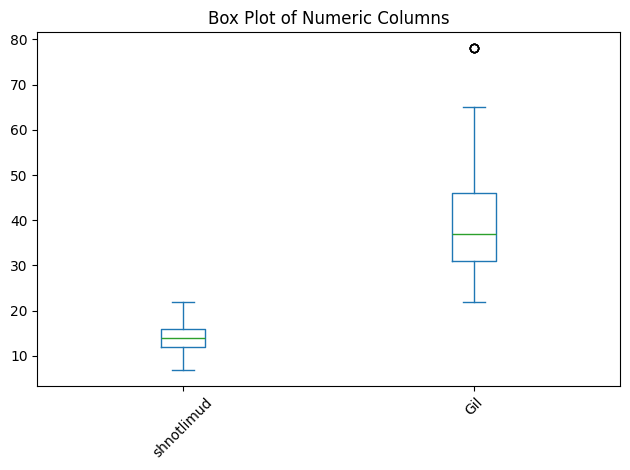

In [1115]:
# check anomlies in the numeric columns
df_survey[[
 'shnotlimud','Gil']].plot.box()
plt.title("Box Plot of Numeric Columns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1116]:
corr_all_columns= df_survey[[col for col in df_survey.columns if df_survey[col].dtype != 'object']].corr()
corr_all_columns

,ID,MenahelEtMi,MaamadAvoda,MakorSachar,TeudaGvoha,shnotlimud,Gil,TarichHathala,SemelMishlachSofi_1,SemelAnafSofi_1,YeshuvAvoda_1,ShemAvoda_1,SugAvoda_1,ShemMachlaka_1,SugMachlaka_1,EzoAvoda_1,TeurPeula_1
ID,1.000000,-0.249673,0.009576,-0.023255,-0.172731,-0.207389,-0.099193,0.052768,0.036141,-0.085065,0.103402,0.043137,0.162341,0.004239,0.216258,0.016320,0.120543
MenahelEtMi,-0.249673,1.000000,-0.261257,-0.457662,0.414511,0.479629,0.434567,0.059137,-0.591899,0.125836,-0.021147,0.194505,-0.558518,-0.084130,-0.006469,-0.076881,-0.435356
MaamadAvoda,0.009576,-0.261257,1.000000,0.006590,-0.120218,-0.167534,0.398030,0.134439,0.358688,-0.287398,-0.103888,0.110575,-0.172213,-0.127691,-0.274745,-0.239572,0.060875
MakorSachar,-0.023255,-0.457662,0.006590,1.000000,-0.337547,-0.372826,0.076424,0.189505,0.195021,0.034233,-0.112362,0.202685,-0.023247,0.074181,0.090706,-0.025802,0.221228
TeudaGvoha,-0.172731,0.414511,-0.120218,-0.337547,1.000000,0.887982,0.270566,-0.299522,-0.668511,0.183667,0.090941,-0.290825,-0.055196,-0.208999,-0.014753,-0.151583,-0.226995
shnotlimud,-0.207389,0.479629,-0.167534,-0.372826,0.887982,1.000000,0.234946,-0.170843,-0.609411,0.241169,0.027849,-0.301995,-0.107732,-0.186739,-0.030899,-0.127345,-0.264530
Gil,-0.099193,0.434567,0.398030,0.076424,0.270566,0.234946,1.000000,-0.292601,-0.138365,-0.209475,-0.036609,-0.049516,-0.187362,-0.099280,-0.228354,-0.151185,0.086222
TarichHathala,0.052768,0.059137,0.134439,0.189505,-0.299522,-0.170843,-0.292601,1.000000,0.271128,0.089831,-0.012287,0.116373,0.050247,0.306490,0.049840,0.257922,0.017687
SemelMishlachSofi_1,0.036141,-0.591899,0.358688,0.195021,-0.668511,-0.609411,-0.138365,0.271128,1.000000,-0.280323,-0.052625,0.046175,-0.096655,0.162498,-0.230292,-0.101139,0.106369
SemelAnafSofi_1,-0.085065,0.125836,-0.287398,0.034233,0.183667,0.241169,-0.209475,0.089831,-0.280323,1.000000,-0.110393,0.143668,0.066876,0.124036,-0.022460,0.281598,0.035907


In [1117]:
corr_all_columns.sort_values(['SemelMishlachSofi_1'])['SemelMishlachSofi_1']

,SemelMishlachSofi_1
TeudaGvoha,-0.668511
shnotlimud,-0.609411
MenahelEtMi,-0.591899
SemelAnafSofi_1,-0.280323
SugMachlaka_1,-0.230292
Gil,-0.138365
EzoAvoda_1,-0.101139
SugAvoda_1,-0.096655
YeshuvAvoda_1,-0.052625
ID,0.036141


In [1118]:
tehuda_map={ 'yesodi':1,
            'tichon': 2,
            'bagrut':3 ,
            'al tichoni':4,
            'BA':5,
            'MA':6,
           'PHD':7}

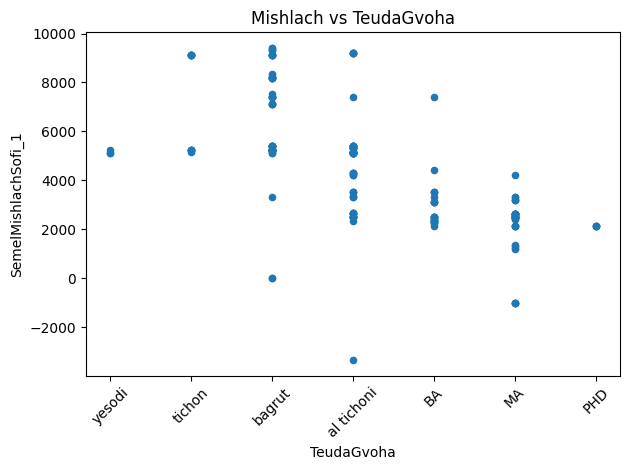

In [1119]:
df_survey.plot.scatter(x='TeudaGvoha', y='SemelMishlachSofi_1', title='Mishlach vs TeudaGvoha')
plt.xticks(
    ticks=list(tehuda_map.values()),  # [0, 1, 2, 3, 4, 5]
    labels=list(tehuda_map.keys()),   # ['Coronary Heart Disease', ...]
    rotation=45                         # Optional: rotate for better readability
)
plt.tight_layout()
plt.show()

In [1188]:
# by the Graph above we can see that BA , MA and PHD got jobs uder 6000

In [1120]:
MenahelEtMi_map={'manage workers':1,
                 'manage managers':2,
                'manage both':3
}

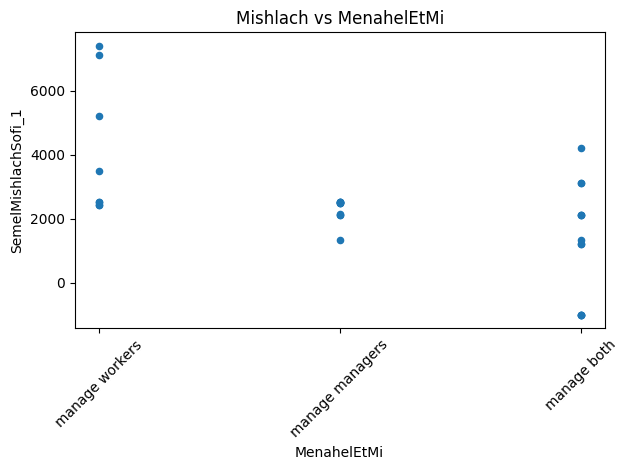

In [1121]:
df_survey.plot.scatter(x='MenahelEtMi', y='SemelMishlachSofi_1', title='Mishlach vs MenahelEtMi')
plt.xticks(
    ticks=list(MenahelEtMi_map.values()),  # [0, 1, 2, 3, 4, 5]
    labels=list(MenahelEtMi_map.keys()),   # ['Coronary Heart Disease', ...]
    rotation=45                         # Optional: rotate for better readability
)
plt.tight_layout()
plt.show()

In [1189]:
# by the Graph above we can see that manage manager and manage both got job number under 4000

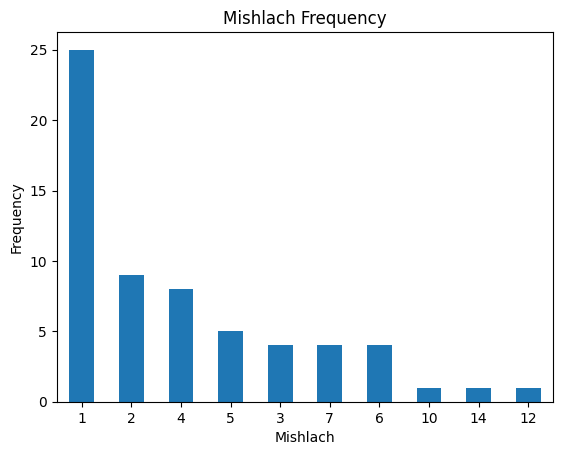

In [1122]:
# by the histogram below I can see the data is divided equly except from Autoimmune Disorder
#it could lead to imbalance model in this specific disease
df_count_mishlach=df_survey.groupby('SemelMishlachSofi_1').agg(count_id=('ID','count')).reset_index()
df_count_mishlach.count_id.value_counts().plot(kind='bar', title='Mishlach Frequency')
plt.xticks(rotation=360)
plt.xlabel('Mishlach')
plt.ylabel('Frequency')
plt.show()

#### there are two many classes with 1 row and therefore it will be difficult to predict them there fore I will use the text to group between the classes and predict a group of classes the grouping will be by embedding similarity

# Data Preperation

### date split to columns

In [1123]:
# split date columns into year,month,weekofyear,quarter
def Date_split(df,column):

    if column not in df.columns : return(print('No such column in dataframe'))

    df[column+'_year'] = pd.DatetimeIndex(df[column]).year
    df[column+'_month'] = pd.DatetimeIndex(df[column]).month
    df[column+'_quarter'] = pd.DatetimeIndex(df[column]).quarter


    return

In [1124]:
Date_split(df_survey,'TarichHathala')

In [1125]:
df_survey[['TarichHathala','TarichHathala_year','TarichHathala_month','TarichHathala_quarter']]

,TarichHathala,TarichHathala_year,TarichHathala_month,TarichHathala_quarter
0,2020-06-15,2020.0,6.0,2.0
1,2022-07-01,2022.0,7.0,3.0
2,2021-06-06,2021.0,6.0,2.0
3,2024-07-01,2024.0,7.0,3.0
4,2010-01-11,2010.0,1.0,1.0
...,...,...,...,...
196,2000-07-15,2000.0,7.0,3.0
197,2024-07-31,2024.0,7.0,3.0
198,2011-02-01,2011.0,2.0,1.0
199,2023-02-01,2023.0,2.0,1.0


### remove the empty cell in SemelMishlachSofi ( target value)

In [1126]:
df_survey_prod=df_survey[~df_survey['SemelMishlachSofi'].isnull()].copy()

In [1127]:
df_survey_prod.shape

(200, 30)

### change text to embedding in order to group some SemelMishlachSofi

In [1128]:
model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v2")

In [1129]:
# Text columns to combine for job meaning
text_cols_1 = ["EzoAvoda", "TeurPeula", "TeurTafkid"]
text_cols_2=["SugAvoda","ShemMachlaka", "SugMachlaka","ShemAvoda"]

In [1130]:
def concatenate_text_columns(df, text_cols_1, text_cols_2):
    """
    Concatenates text columns from text_cols_1, falling back to text_cols_2
    if columns in text_cols_1 are empty. Ignores the word "כנ"ל" and avoids adding
    duplicate column content.

    Args:
        df (pd.DataFrame): The input DataFrame.
        text_cols_1 (list): A list of column names to prioritize for concatenation.
        text_cols_2 (list): A list of column names to use if text_cols_1 are empty.

    Returns:
        pd.Series: A Series containing the concatenated text.
    """
    def combine_cols(row, cols):
        combined_text = []
        for col in cols:
            col_content = str(row[col]).strip() if pd.notna(row[col]) else ""
            cleaned_content = " ".join([word for word in col_content.split() if word != 'כנ"ל'])

            if cleaned_content and cleaned_content not in " ".join(combined_text):
                combined_text.append(cleaned_content)
        return " ".join(combined_text)

    combined_text_1 = df.apply(lambda row: combine_cols(row, text_cols_1), axis=1)
    combined_text_2 = df.apply(lambda row: combine_cols(row, text_cols_2), axis=1)

    # Use combined_text_1 if not empty, otherwise use combined_text_2
    combined_text = combined_text_1.where(combined_text_1 != '', combined_text_2)

    return combined_text

In [1131]:
df_survey_prod['combined_job_text']=concatenate_text_columns(df_survey_prod,text_cols_1,text_cols_2)

In [1132]:
df_survey_prod[["EzoAvoda", "TeurPeula", "TeurTafkid", "SugAvoda",
                "ShemMachlaka", "SugMachlaka","ShemAvoda","combined_job_text"]].head()

,EzoAvoda,TeurPeula,TeurTafkid,SugAvoda,ShemMachlaka,SugMachlaka,ShemAvoda,combined_job_text
0,סגן מנהל אגף,"כנ""ל",סגן מנהל אגף,"איסוף, עיבוד ופרסום נתונים",מיקרו כלכלה,טיפול בנתוני מיקרו,"למ""ס",סגן מנהל אגף
1,טכנאית רדיותרפיה,"כנ""ל","כנ""ל",טיפול בחולים,רדיואתרפיה,טיפול בחולי סרטן,בית חולים הדסה עין כרם,טכנאית רדיותרפיה
2,נותנת תמיכה ללקוחות שמבקשים עזרה,מסבירה איך להשתמש בשירותים ממשלתיים באתר האינטרנט,NaN,מתן שירות למשתמשים באתר GOV,תמיכה בלקוחות,"כנ""ל",קריית הממשלה,נותנת תמיכה ללקוחות שמבקשים עזרה מסבירה איך לה...
3,שומר בבית הספר,NaN,NaN,בית ספר יסודי,שמירה,NaN,משרד החינוך,שומר בבית הספר
4,מטפל בקשיש,"נותן אוכל, עוזר בניקיון בית, עוזר להתרחץ",NaN,מטפל בקשיש במשפחה,NaN,NaN,אמיר כהן,"מטפל בקשיש נותן אוכל, עוזר בניקיון בית, עוזר ל..."


In [1133]:
embeddings = model.encode(df_survey_prod['combined_job_text'], show_progress_bar=True, normalize_embeddings=True)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [1134]:
embeddings.shape

(200, 512)

In [1135]:
# embeddings: shape (num_rows, embedding_dim)
similarity_matrix = cosine_similarity(embeddings)

# Optional: convert to DataFrame if you want to visualize
sim_df = pd.DataFrame(similarity_matrix, index=df_survey_prod.SemelMishlachSofi_1,
                      columns=df_survey_prod.SemelMishlachSofi_1)
display(sim_df.head())

SemelMishlachSofi_1,2120.0,3311.0,3512.0,5414.0,5322.0,5412.0,3122.0,2512.0,5230.0,2514.0,...,5412.0,5131.0,-1.0,7412.0,5131.0,5412.0,5131.0,5142.0,2342.0,4413.0
SemelMishlachSofi_1,,,,,,,,,,,,,,,,,,,,,
2120.0,1.000000,0.371763,-0.040654,0.367808,0.044386,0.610455,0.124021,0.243003,0.433660,0.279607,...,0.610455,0.373116,0.200125,-0.048409,0.373116,0.350321,0.373116,0.333542,0.371995,0.139001
3311.0,0.371763,1.000000,-0.055975,0.158080,-0.059906,0.273416,0.083930,0.169302,0.321132,0.362916,...,0.273416,0.228076,0.137145,0.041931,0.228076,0.236907,0.228076,0.383995,0.255296,0.142464
3512.0,-0.040654,-0.055975,1.000000,-0.014852,0.325367,-0.006292,0.050223,-0.011561,-0.047429,-0.072438,...,-0.006292,-0.043175,0.315932,0.037926,-0.043175,-0.022995,-0.043175,-0.046692,-0.045037,-0.042577
5414.0,0.367808,0.158080,-0.014852,1.000000,0.106504,0.312631,0.139443,-0.050419,0.317282,0.175448,...,0.312631,0.279817,0.058927,-0.016820,0.279817,0.311030,0.279817,0.283875,0.309924,-0.037247
5322.0,0.044386,-0.059906,0.325367,0.106504,1.000000,0.012789,0.326039,0.090343,0.012366,-0.014944,...,0.012789,0.007804,0.209568,0.080923,0.007804,0.030298,0.007804,-0.005520,0.026619,0.111976


In [1136]:
job_counts = df_survey_prod['SemelMishlachSofi_1'].value_counts()

In [1137]:
rare_jobs=job_counts[job_counts<4].index

In [1138]:
job_to_group = {}

for job in rare_jobs:
    idx = df_survey_prod.index[df_survey_prod['SemelMishlachSofi_1'] == job][0]
    similarities = similarity_matrix[idx]
    idx_to_set=df_survey_prod.index[df_survey_prod['SemelMishlachSofi_1'] == job]
    # Ignore itself by setting self-similarity to -1
    similarities[idx_to_set] = -1

    # Find the most similar job in the dataset
    most_similar_idx = np.argmax(similarities)
    most_similar_job = df_survey.iloc[most_similar_idx]['SemelMishlachSofi_1']

    job_to_group[job] = most_similar_job

df_rare_simi=pd.DataFrame(list(job_to_group.items()), columns=['RareJob', 'GroupedTo'])

In [1139]:
df_rare_simi.head(1).T

,0
RareJob,2131.0
GroupedTo,2113.0


In [1140]:
df_rare_simi_1=df_rare_simi.merge(df_survey_prod[['SemelMishlachSofi_1','combined_job_text']].drop_duplicates(),
                   left_on='RareJob', right_on='SemelMishlachSofi_1')\
                   .merge(df_survey_prod[['SemelMishlachSofi_1','combined_job_text']].drop_duplicates(),
                   left_on='GroupedTo', right_on='SemelMishlachSofi_1',suffixes=('_rare','_to'))\
                    [['RareJob','combined_job_text_rare','GroupedTo','combined_job_text_to']].drop_duplicates(subset=['RareJob','GroupedTo'])

In [1141]:
df_rare_simi_1

,RareJob,combined_job_text_rare,GroupedTo,combined_job_text_to
0,2131.0,חוקר במעבדה ביולוגית,2113.0,חוקר במעבדה
2,3211.0,טכנאית רדיותרפיה,3311.0,טכנאית רדיותרפיה
3,2120.0,סגן מנהל אגף,2330.0,מורה למתמתיקה
5,7127.0,התקנת מזגנים בדירות חדשות טכנאי מזגנים,7414.0,התקנת חשמל בדירות חדשות עוזר לחשמלאי
7,3323.0,מטפל בהזמנות של ציוד שונה להצגות,9412.0,שוטף כלים
8,3513.0,מתחזק רשת מחשבים נותן תמיכה לעובדים בבנק ופוטר...,3512.0,נותנת תמיכה ללקוחות שמבקשים עזרה מסבירה איך לה...
11,7412.0,חשמלאי של רכבים חשמליים תיקון מערכות חשמל וטעי...,7414.0,התקנת חשמל בדירות חדשות עוזר לחשמלאי
15,2142.0,תכנון צינורות,8342.0,חופר תעלות
17,8212.0,עובד בפס ייצור,9329.0,עובד כללי
18,9412.0,שוטף כלים,8342.0,חופר תעלות


In [1142]:
def get_final_grp(df):
  # set the new group to some value
  df_rare_simi_1['new_job_group']=df_rare_simi_1['GroupedTo']*1000
  G = nx.Graph()
  for a, b in zip(df['RareJob'], df['GroupedTo']):
      G.add_edge(a, b)

  # Step 2: Find connected components
  components = list(nx.connected_components(G))

  # Step 3: Assign the minimum new_job_group to all in the same component
  mapping = {}
  for comp in components:
      # find rows related to this component
      comp_groups = df[df['RareJob'].isin(comp) | df['GroupedTo'].isin(comp)]['new_job_group']
      min_group = comp_groups.min()  # choose the smallest code
      for node in comp:
          mapping[node] = min_group

  # Step 4: Map to DataFrame
  del df['new_job_group']
  df['final_job_group'] = df['RareJob'].map(mapping)

In [1143]:
get_final_grp(df_rare_simi_1)

In [1144]:
df_rare_simi_1.sort_values('final_job_group')

,RareJob,combined_job_text_rare,GroupedTo,combined_job_text_to,final_job_group
30,3354.0,קבלת קהל,-3350.0,קבלת קהל,-3350000.0
22,4211.0,קבלת קהל,3354.0,קבלת קהל,-3350000.0
48,-3350.0,קבלת קהל,3354.0,קבלת קהל,-3350000.0
24,2262.0,רוקח,-1000.0,לא יכול לפרט,-1000000.0
41,4227.0,סוקר,-1000.0,לא יכול לפרט,-1000000.0
17,8212.0,עובד בפס ייצור,9329.0,עובד כללי,-1000.0
19,9329.0,עובד כללי,-1.0,מסעדה,-1000.0
69,5419.0,מציל בבריכה,-1.0,מסעדה,-1000.0
45,1212.0,מנהלת משאבי אנוש מנהלת משאבי אנוש של עובדיםן ב...,2423.0,מנהלת משאבי אנוש,1212000.0
49,2423.0,מנהלת משאבי אנוש,1212.0,מנהלת משאבי אנוש מנהלת משאבי אנוש של עובדיםן ב...,1212000.0


In [1145]:
df_survey_prod=df_survey_prod.merge(df_rare_simi_1[['RareJob','final_job_group']],
                                    how='left',left_on='SemelMishlachSofi_1',right_on='RareJob')\
                                    .merge(df_rare_simi_1[['GroupedTo','final_job_group']].drop_duplicates(),
                                    how='left',left_on='SemelMishlachSofi_1',right_on='GroupedTo',
                                           suffixes=('_rare','_to'))

In [1146]:
df_survey_prod[['SemelMishlachSofi_1','final_job_group_rare','final_job_group_to']]

,SemelMishlachSofi_1,final_job_group_rare,final_job_group_to
0,2120.0,1221000.0,1221000.0
1,3311.0,3211000.0,3211000.0
2,3512.0,NaN,3512000.0
3,5414.0,NaN,5414000.0
4,5322.0,NaN,NaN
...,...,...,...
195,5412.0,NaN,NaN
196,5131.0,NaN,5131000.0
197,5142.0,NaN,NaN
198,2342.0,NaN,NaN


In [1147]:
df_survey_prod['final_job_group'] = np.where((~df_survey_prod['final_job_group_rare'].isnull()),
                                             df_survey_prod['final_job_group_rare'],
                                             np.where((~df_survey_prod['final_job_group_to'].isnull()),
                                                      df_survey_prod['final_job_group_to'],
                                                      df_survey_prod['SemelMishlachSofi_1']))


In [1148]:
df_survey_prod[['SemelMishlachSofi_1','final_job_group_to','final_job_group_rare','final_job_group']]

,SemelMishlachSofi_1,final_job_group_to,final_job_group_rare,final_job_group
0,2120.0,1221000.0,1221000.0,1221000.0
1,3311.0,3211000.0,3211000.0,3211000.0
2,3512.0,3512000.0,NaN,3512000.0
3,5414.0,5414000.0,NaN,5414000.0
4,5322.0,NaN,NaN,5322.0
...,...,...,...,...
195,5412.0,NaN,NaN,5412.0
196,5131.0,5131000.0,NaN,5131000.0
197,5142.0,NaN,NaN,5142.0
198,2342.0,NaN,NaN,2342.0


In [1149]:
df_survey_prod['final_job_group'].nunique()

29

In [1190]:
# there are 29 groups of jobs instead of 62 gobs, maybe we can lower it later, but final_job_group is the new target

In [1151]:
df_survey_prod_arch=df_survey_prod.copy()

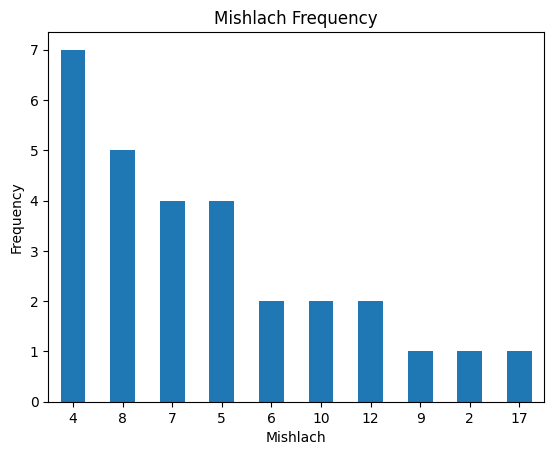

In [1191]:
# by the histogram below I can see the data is divided equly except from Autoimmune Disorder
#it could lead to imbalance model in this specific disease
df_count_mishlach=df_survey_prod_arch.groupby('final_job_group').agg(count_id=('ID','count')).reset_index()
df_count_mishlach.count_id.value_counts().plot(kind='bar', title='Mishlach Frequency')
plt.xticks(rotation=360)
plt.xlabel('Mishlach')
plt.ylabel('Frequency')
plt.show()

### updtae categorial

In [1019]:
def update_catgorial_by_one_hot_encoder(df,column):
    encoder = OneHotEncoder(sparse_output=False)
    column_encoded = encoder.fit_transform(df[[column]])
    column_encoded_df = pd.DataFrame(column_encoded, columns=column+'_'+encoder.categories_[0])
    df = pd.concat([df, column_encoded_df], axis=1)

    return df

In [1020]:
df_survey_prod=update_catgorial_by_one_hot_encoder(df_survey_prod,'YeshuvAvoda')

In [1021]:
df_survey_prod.head()

,ID,YeshuvAvoda,ShemAvoda,SugAvoda,ShemMachlaka,SugMachlaka,EzoAvoda,TeurPeula,TeurTafkid,MenahelEtMi,...,YeshuvAvoda_מודיעין,YeshuvAvoda_מעלה החמישה,YeshuvAvoda_משמר השרון,YeshuvAvoda_נוף הגליל,YeshuvAvoda_עפולה,YeshuvAvoda_קריית גת,YeshuvAvoda_קרית גת,YeshuvAvoda_רעננה,YeshuvAvoda_שדרות,YeshuvAvoda_תל אביב
0,1.0,ירושלים,"למ""ס","איסוף, עיבוד ופרסום נתונים",מיקרו כלכלה,טיפול בנתוני מיקרו,סגן מנהל אגף,"כנ""ל",סגן מנהל אגף,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,ירושלים,בית חולים הדסה עין כרם,טיפול בחולים,רדיואתרפיה,טיפול בחולי סרטן,טכנאית רדיותרפיה,"כנ""ל","כנ""ל",NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,באר שבע,קריית הממשלה,מתן שירות למשתמשים באתר GOV,תמיכה בלקוחות,"כנ""ל",נותנת תמיכה ללקוחות שמבקשים עזרה,מסבירה איך להשתמש בשירותים ממשלתיים באתר האינטרנט,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,תל אביב,משרד החינוך,בית ספר יסודי,שמירה,NaN,שומר בבית הספר,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5.0,תל אביב,אמיר כהן,מטפל בקשיש במשפחה,NaN,NaN,מטפל בקשיש,"נותן אוכל, עוזר בניקיון בית, עוזר להתרחץ",NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### column to use for the model

In [1022]:
df_survey_prod.head(1).T

,0
ID,1.0
YeshuvAvoda,ירושלים
ShemAvoda,"למ""ס"
SugAvoda,"איסוף, עיבוד ופרסום נתונים"
ShemMachlaka,מיקרו כלכלה
SugMachlaka,טיפול בנתוני מיקרו
EzoAvoda,סגן מנהל אגף
TeurPeula,"כנ""ל"
TeurTafkid,סגן מנהל אגף
MenahelEtMi,3.0


In [1023]:
# removed the column of ID , all the text columns which I used the group the target value
# and regardin TarichHathala I used the columns I split it and get a ll the OneHotEncoding from  YeshuvAvoda
col_to_use=['MenahelEtMi','MaamadAvoda','MakorSachar','TeudaGvoha','shnotlimud','SemelAnafSofi_1','Gil',
            'TarichHathala_year','TarichHathala_month','TarichHathala_quarter','YeshuvAvoda_אופקים',
            'YeshuvAvoda_אילת',
            'YeshuvAvoda_אשקלון',
            'YeshuvAvoda_באר שבע',
            'YeshuvAvoda_בת ים',
            'YeshuvAvoda_הרצליה',
              'YeshuvAvoda_חדרה',
              'YeshuvAvoda_חיפה',
              'YeshuvAvoda_חצור',
              'YeshuvAvoda_יוקנעם',
              'YeshuvAvoda_ירושלים',
              'YeshuvAvoda_מודיעין',
              'YeshuvAvoda_מעלה החמישה',
              'YeshuvAvoda_משמר השרון',
              'YeshuvAvoda_נוף הגליל',
              'YeshuvAvoda_עפולה',
              'YeshuvAvoda_קריית גת',
              'YeshuvAvoda_קרית גת',
              'YeshuvAvoda_רעננה',
              'YeshuvAvoda_שדרות',
              'YeshuvAvoda_תל אביב',
            'final_job_group']


In [1024]:
df_survey_prod=df_survey_prod[col_to_use].copy()

In [1025]:
df_survey_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MenahelEtMi              32 non-null     float64
 1   MaamadAvoda              198 non-null    float64
 2   MakorSachar              186 non-null    float64
 3   TeudaGvoha               198 non-null    float64
 4   shnotlimud               198 non-null    float64
 5   SemelAnafSofi_1          200 non-null    float64
 6   Gil                      198 non-null    float64
 7   TarichHathala_year       200 non-null    float64
 8   TarichHathala_month      200 non-null    float64
 9   TarichHathala_quarter    200 non-null    float64
 10  YeshuvAvoda_אופקים       200 non-null    float64
 11  YeshuvAvoda_אילת         200 non-null    float64
 12  YeshuvAvoda_אשקלון       200 non-null    float64
 13  YeshuvAvoda_באר שבע      200 non-null    float64
 14  YeshuvAvoda_בת ים        2

In [1026]:
# i fill nulls with data in all columns the  becuase I don't have many columns
#and I don't want to remove one of them
def fill_nulls(df):
    """
    Fills null values in specific columns of the DataFrame based on predefined logic.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with null values filled.
    """
    # Fill nulls in 'MenahelEtMi' with 0, assume they are not mangers
    df['MenahelEtMi'] = df['MenahelEtMi'].fillna(0)

    # Fill nulls in 'MaamadAvoda' with the most frequent value
    most_frequent_maamad = df['MaamadAvoda'].mode()[0]
    df['MaamadAvoda'] = df['MaamadAvoda'].fillna(most_frequent_maamad)

    # Fill nulls in 'MakorSachar' with 4 which is other
    df['MakorSachar'] = df['MakorSachar'].fillna(4)

    # Fill nulls in 'TeudaGvoha' with 8 which is other
    df['TeudaGvoha'] = df['TeudaGvoha'].fillna(8)

    # Fill nulls in 'shnotlimud' with the most frequent value
    most_frequent_shnotlimud = df['shnotlimud'].mode()[0]
    df['shnotlimud'] = df['shnotlimud'].fillna(most_frequent_shnotlimud)

    # Fill nulls in 'Gil' with the integer part of the mean
    mean_gil = int(df['Gil'].mean())
    df['Gil'] = df['Gil'].fillna(mean_gil)

    return df

In [1027]:
df_survey_prod=fill_nulls(df_survey_prod)

In [1028]:
df_survey_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MenahelEtMi              200 non-null    float64
 1   MaamadAvoda              200 non-null    float64
 2   MakorSachar              200 non-null    float64
 3   TeudaGvoha               200 non-null    float64
 4   shnotlimud               200 non-null    float64
 5   SemelAnafSofi_1          200 non-null    float64
 6   Gil                      200 non-null    float64
 7   TarichHathala_year       200 non-null    float64
 8   TarichHathala_month      200 non-null    float64
 9   TarichHathala_quarter    200 non-null    float64
 10  YeshuvAvoda_אופקים       200 non-null    float64
 11  YeshuvAvoda_אילת         200 non-null    float64
 12  YeshuvAvoda_אשקלון       200 non-null    float64
 13  YeshuvAvoda_באר שבע      200 non-null    float64
 14  YeshuvAvoda_בת ים        2

In [1029]:
df_survey_prod.describe()

,MenahelEtMi,MaamadAvoda,MakorSachar,TeudaGvoha,shnotlimud,SemelAnafSofi_1,Gil,TarichHathala_year,TarichHathala_month,TarichHathala_quarter,...,YeshuvAvoda_מעלה החמישה,YeshuvAvoda_משמר השרון,YeshuvAvoda_נוף הגליל,YeshuvAvoda_עפולה,YeshuvAvoda_קריית גת,YeshuvAvoda_קרית גת,YeshuvAvoda_רעננה,YeshuvAvoda_שדרות,YeshuvAvoda_תל אביב,final_job_group
count,200.00000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,2.000000e+02
mean,0.34500,1.405000,1.52500,4.165000,14.290000,5671.800000,39.450000,2016.950000,7.615000,2.960000,...,0.015000,0.015000,0.010000,0.015000,0.005000,0.030000,0.065000,0.015000,0.175000,1.883972e+06
std,0.85418,1.244475,0.96646,1.373758,2.911751,2961.082297,12.547698,8.320073,3.104022,0.923398,...,0.121857,0.121857,0.099748,0.121857,0.070711,0.171015,0.247144,0.121857,0.380921,2.464138e+06
min,0.00000,1.000000,1.00000,1.000000,7.000000,-8520.000000,22.000000,1999.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.350000e+06
25%,0.00000,1.000000,1.00000,3.000000,12.000000,4711.000000,31.000000,2011.000000,6.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.122000e+03
50%,0.00000,1.000000,1.00000,4.000000,14.000000,6201.000000,37.000000,2022.000000,7.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.221000e+06
75%,0.00000,1.000000,2.00000,5.000000,16.000000,8168.500000,46.000000,2022.000000,11.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.512000e+06
max,3.00000,6.000000,4.00000,8.000000,22.000000,9602.000000,78.000000,2026.000000,12.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.414000e+06


# run the classification model

### split Data

In [1030]:
df_survey_prod.final_job_group.value_counts()

,count
final_job_group,
2412000.0,17
9112.0,12
5131000.0,12
2512.0,10
7414000.0,10
-1000.0,9
2631000.0,8
5414000.0,8
2511000.0,8


In [1031]:
X = df_survey_prod.drop('final_job_group', axis=1)
y = df_survey_prod.final_job_group

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,stratify=y, random_state=0)

In [1032]:
X_train.shape, X_test.shape

((160, 31), (40, 31))

In [1033]:
df_survey_prod.final_job_group.unique()

array([ 1.221e+06,  3.211e+06,  3.512e+06,  5.414e+06,  5.322e+03,
        5.412e+03,  3.122e+03,  2.512e+03,  5.230e+06,  2.514e+03,
        2.631e+06,  5.131e+06, -1.000e+03,  2.412e+06,  5.142e+03,
       -1.000e+06,  2.342e+03,  2.635e+03,  4.313e+03,  2.113e+06,
        8.183e+03,  2.511e+06,  9.112e+03,  5.120e+06,  9.211e+03,
        7.414e+06,  2.655e+03, -3.350e+06,  1.212e+06])

### run model 1- Decision Tree

In [1034]:
param_grid = {
  "criterion": ["gini", "entropy"],
  "max_depth": [None, 5, 10, 20],
  "min_samples_split": [2, 5, 10],
  "min_samples_leaf": [1, 2, 4],
  "max_features": ["sqrt", "log2", None],
  "class_weight": [None, "balanced"]
  }

In [1062]:
def Grid_Search_CV(X_train, y_train, model,scorer,param_grid):
    estimator = model


    grid = GridSearchCV(estimator, param_grid,scoring=scorer, n_jobs=-1, cv=3)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_

In [1036]:
# i used f1_weighted because there are imbalanced classes
#and from my prespective prescion and recall they have the same importance

In [1037]:
scorrer='f1_weighted'

In [1038]:
X_train.head()

,MenahelEtMi,MaamadAvoda,MakorSachar,TeudaGvoha,shnotlimud,SemelAnafSofi_1,Gil,TarichHathala_year,TarichHathala_month,TarichHathala_quarter,...,YeshuvAvoda_מודיעין,YeshuvAvoda_מעלה החמישה,YeshuvAvoda_משמר השרון,YeshuvAvoda_נוף הגליל,YeshuvAvoda_עפולה,YeshuvAvoda_קריית גת,YeshuvAvoda_קרית גת,YeshuvAvoda_רעננה,YeshuvAvoda_שדרות,YeshuvAvoda_תל אביב
37,3.0,1.0,1.0,5.0,15.0,2610.0,65.0,1999.0,7.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
197,0.0,4.0,1.0,3.0,12.0,9602.0,35.0,2024.0,7.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,0.0,1.0,1.0,3.0,12.0,2630.0,25.0,2015.0,7.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155,0.0,1.0,2.0,2.0,10.0,8121.0,28.0,2022.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
106,0.0,1.0,1.0,3.0,14.0,5610.0,23.0,2022.0,8.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1039]:
Grid_Search_CV(X_train, y_train, DecisionTreeClassifier(),scorrer,param_grid)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


(np.float64(0.7458630952380951),
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 20,
  'max_features': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2})



```
### final model tree
```



In [1048]:
clf = DecisionTreeClassifier(random_state=42,class_weight='balanced',
                            criterion= 'entropy',max_depth=20,
                             min_samples_leaf=1,min_samples_split= 2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

## check accuracy

In [1049]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1050]:
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print("Weighted F1 Score:", round(f1_weighted,3))

Weighted F1 Score: 0.695


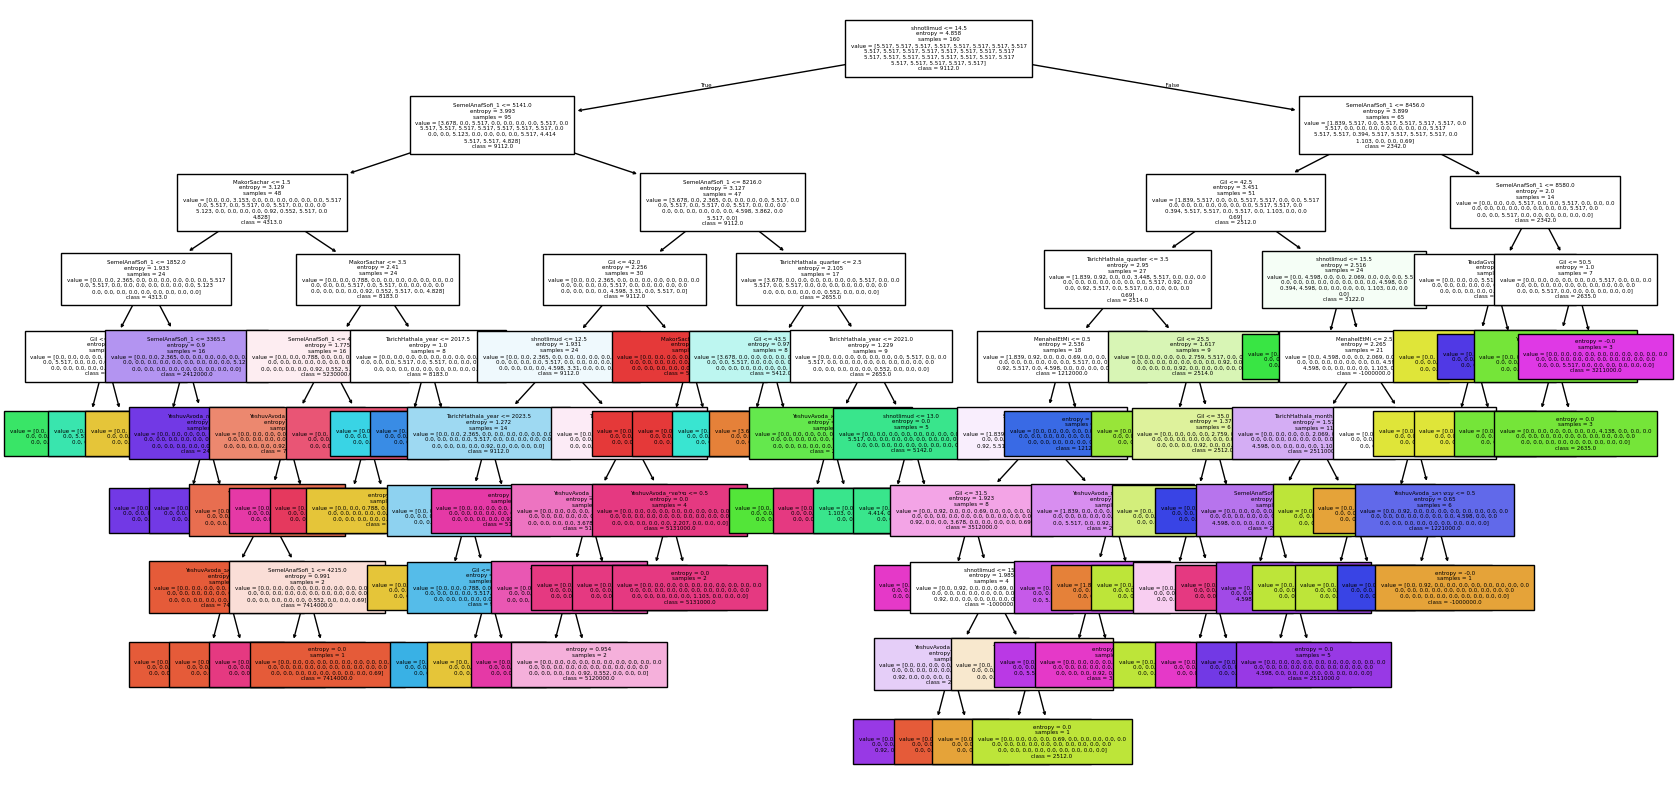

In [1051]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=clf.classes_.astype(str),fontsize=4)
plt.show()

### feature importance

In [1052]:
def create_feature_importance(X,model):
    features=X.columns
    # Get feature importances from a trained tree model
    importances = model.feature_importances_
    feature_names = X.columns

    # Create a pandas Series for easier sorting
    feat_imp = pd.Series(importances, index=feature_names)

    # Sort by importance (optional)
    feat_imp = feat_imp.sort_values()

    # Plot vertically (horizontal bars)
    plt.figure(figsize=(8, 10))  # Adjust the size as needed
    plt.barh(feat_imp.index, feat_imp.values)
    plt.xlabel("Feature Importance")
    plt.title("Vertical Chart of Feature Importances")
    plt.tight_layout()
    plt.show()
    return

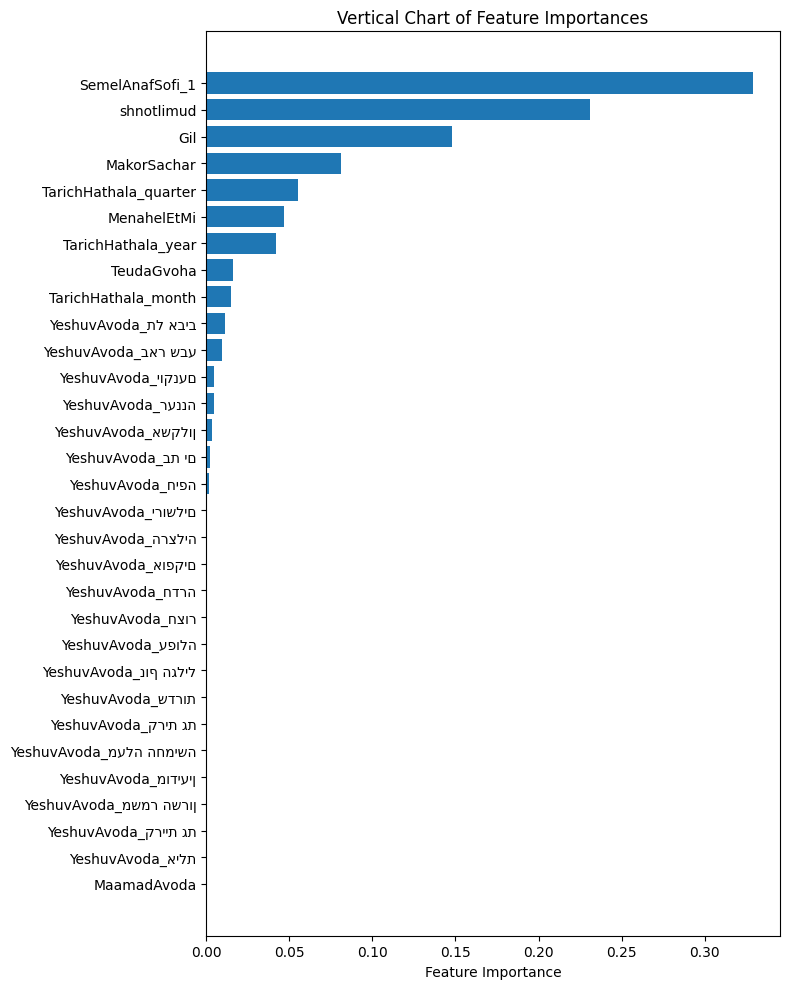

In [1053]:
create_feature_importance(X,clf)

In [1054]:
# need to ask if we can use semelAnafSofi from the buisness prespective

## run model 2 - XGBoost

### grid search

In [1063]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [1056]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)  # if you have a test set

In [1065]:
Grid_Search_CV(X_train, y_train_enc, XGBClassifier(),scorrer,param_grid)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


(np.float64(0.8087888972584989),
 {'colsample_bytree': 1.0,
  'learning_rate': 0.2,
  'max_depth': 3,
  'n_estimators': 50,
  'subsample': 0.8})

In [1068]:
xgb = XGBClassifier( eval_metric='mlogloss',
                      colsample_bytree= 1.0,
                      learning_rate= 0.2,
                      max_depth= 3,
                      n_estimators= 50,
                      subsample= 0.8)
xgb.fit(X_train, y_train_enc)
y_pred = xgb.predict(X_test)

In [1070]:
y_pred_original = le.inverse_transform(y_pred)

In [1083]:
df_preds = pd.DataFrame({
    'y_pred_encoded': y_pred,
    'y_pred_original': y_pred_original
})

print(df_preds.head())

   y_pred_encoded  y_pred_original
0              18        2113000.0
1               1       -1000000.0
2              21        2631000.0
3              10           5142.0
4               4           2512.0


## check accuracy

In [1071]:
print(confusion_matrix(y_test_enc, y_pred))
print(classification_report(y_test_enc, y_pred))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1072]:
f1_weighted = f1_score(y_test_enc, y_pred, average='weighted')
print("Weighted F1 Score:", round(f1_weighted,3))

Weighted F1 Score: 0.686


### feature importance

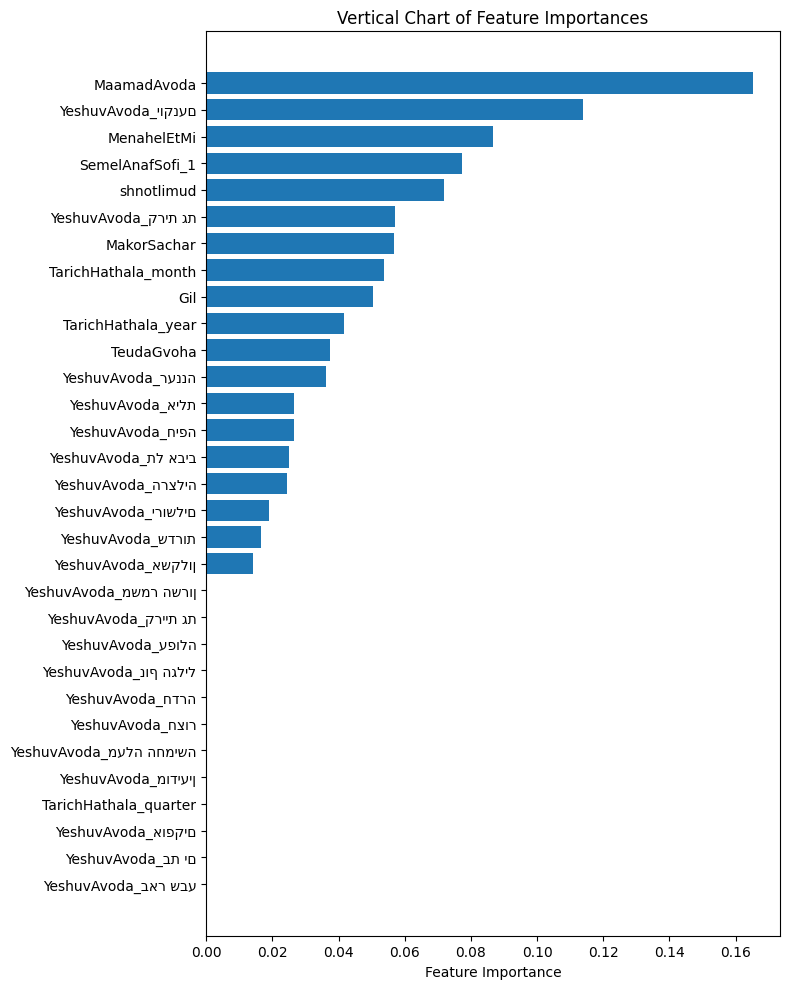

In [1073]:
create_feature_importance(X,xgb)

I will choose XGBoost as the primary model because the accuracy in the models are more or less the same but the but XGBoost distributes feature importance more evenly across the features which can avoid overfitting in new data

#SHAP

In [1074]:
# Initialize the SHAP Explainer
explainer = shap.Explainer(xgb)

In [1075]:
shap_values = explainer.shap_values(X_test)

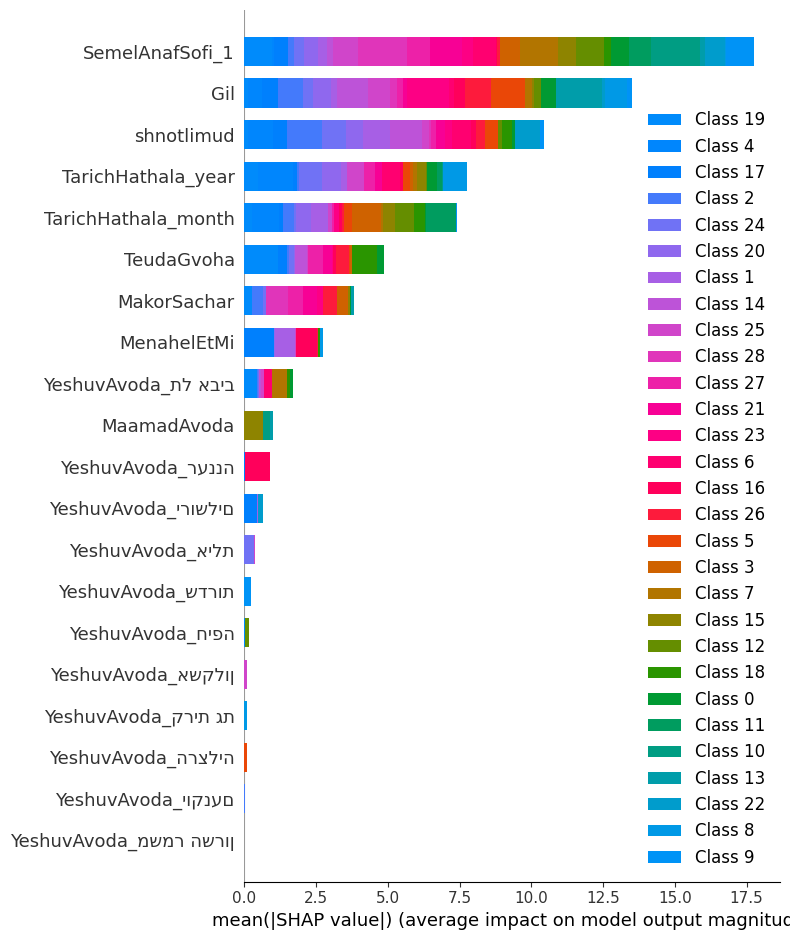

In [1076]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [1077]:
## check per each class the most effective feature ( 1 example)

In [1078]:
def shap_scatter_plot_class_and_feature(shap_values,X_test, column_name, class_number):
    # get real feature data by feature name
    feature_data=X_test.loc[:, column_name].values.reshape(-1, 1)
    # get the index of colmn by name
    column_index = X_test.columns.get_loc(column_name)
    # get shape values of a feature and class
    shap_values_feature_and_class = shap_values[:, column_index, class_number].reshape(-1, 1)
    # create shap object for the plot
    shap_explanation = shap.Explanation(values=shap_values_feature_and_class,
                                    data=feature_data,
                                    feature_names=[column_name])
    # create the plot
    shap.plots.scatter(shap_explanation)
    return

In [1154]:
df_survey_prod_arch[df_survey_prod_arch.final_job_group==df_preds[df_preds['y_pred_encoded']==19]['y_pred_original'].values[0]][['SemelMishlachSofi_1','combined_job_text']]

,SemelMishlachSofi_1,combined_job_text
15,5223.0,יועצת יופי לאנשים מסבירה לאנשים לגבי מוצרים של...
28,5223.0,מורכת
47,5223.0,יועצת יופי לאנשים מסבירה לאנשים לגבי מוצרים של...
60,5223.0,מוכרת
78,5223.0,יועצת יופי לאנשים מסבירה לאנשים לגבי מוצרים של...
91,5223.0,מורכת
110,5223.0,יועצת יופי לאנשים מסבירה לאנשים לגבי מוצרים של...
123,5223.0,מוכרת
149,5223.0,מוכרת
158,5223.0,מוכרת


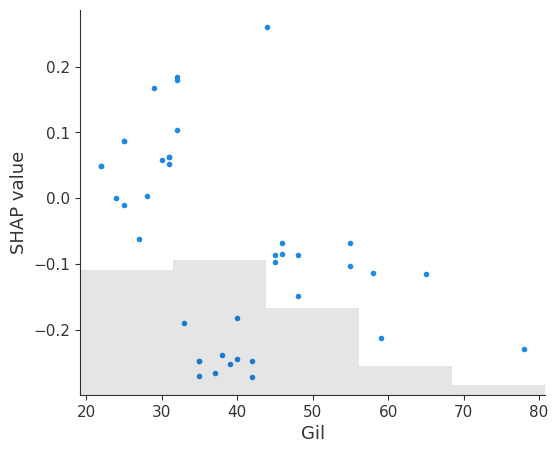

In [1079]:
shap_scatter_plot_class_and_feature(shap_values,X_test,'Gil',19)

In [1156]:
#by the graph above in class 19 ( sales or beuty consult)  when we have more than age 30 ( more and less) it reduce the probability to be in class 19

### analyse the incorrect prediction

In [1172]:
### get the incorrect predictions

In [1169]:
def get_incorrect_prediction_per_class(y_test, y_pred,class_test):
    # Convert the predicted values (y_pred) into a pandas Series with a name 'predict'
    y_pred_series = pd.Series(y_pred, name='predict')

    # Reset the index of the y_test Series to ensure the indices align with y_pred
    # drop=True prevents the old index from being added as a column
    y_test_reset_idx = pd.Series(y_test, name='final_job_group').reset_index(drop=True)

    # Concatenate y_test and y_pred Series along the columns (axis=1)
    # This creates a DataFrame with two columns: 'y_test' (actual values) and 'predict' (predicted values)
    y_compare_df = pd.concat([y_test_reset_idx, y_pred_series], axis=1)
    display(y_compare_df.head())
    y_incorrect_pred_df=y_compare_df[(y_compare_df.final_job_group==class_test) & (y_compare_df.predict!=class_test)]
    # Print the first two rows of the DataFrame to inspect how the data looks
    print('example of incorrect prediction per class ',class_test)
    print(y_incorrect_pred_df.head(2))


    # Return the DataFrame containing actual and predicted values for further analysis
    return y_incorrect_pred_df

In [1171]:
y_incorrect_pred_df=get_incorrect_prediction_per_class(y_test_enc, y_pred,19)

,final_job_group,predict
0,18,18
1,1,1
2,21,21
3,10,10
4,4,4


example of incorrect prediction per class  19
    final_job_group  predict
31               19       21


In [1181]:
columns_name=X_test.columns

In [1176]:
row_index=31

In [1177]:
class_index=19

In [1178]:
expected_value_for_class = explainer.expected_value[class_index]

In [1179]:
 # For multi-class classification, shap_values is a list of arrays (one for each class)
shap_values_for_class = shap_values[:,:,class_index]  # Extract SHAP values for class index

In [1183]:
shap.initjs()

In [1185]:
# create plot for shap
force_plot_ex=shap.plots.force(explainer.expected_value[class_index], shap_values_for_class[row_index],feature_names=columns_name)

In [1186]:
shap.save_html("shap_force_plot.html", force_plot_ex)

In [1187]:
# by the HTML we can see that TeudaGvoha and SemelAnafSofi_1 resuced the probabilities to class 19